This notebook demonstrates how to fine-tune a small shader parameter so that its output image matches a reference image using SlangPY, Torch and mean absolute error (MAE) loss.
- Create a Slang device with CUDA interop enabled.
- Load a differentiable Slang shader as a PyTorch module.
- Prepare an input texture and reference image.
- Define and optimize a learnable brightness offset.
- Display input, reference, and optimized output images inline.

In [7]:
import slangpy
import importlib
_j = importlib.import_module("slangpy.core.jupyter")
_j.slangpy = slangpy
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import torch
import torch.nn.functional as F
import ipynbname

cwd = ipynbname.path()
device : slangpy.Device = slangpy.create_device(
    include_paths=[
        pathlib.Path(cwd).parent.absolute(),
    ],
    enable_cuda_interop=True
)

Errors are too wide for Jupyter, this makes the page wider:
```
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
```

Load source image and reference that we'd like to match:

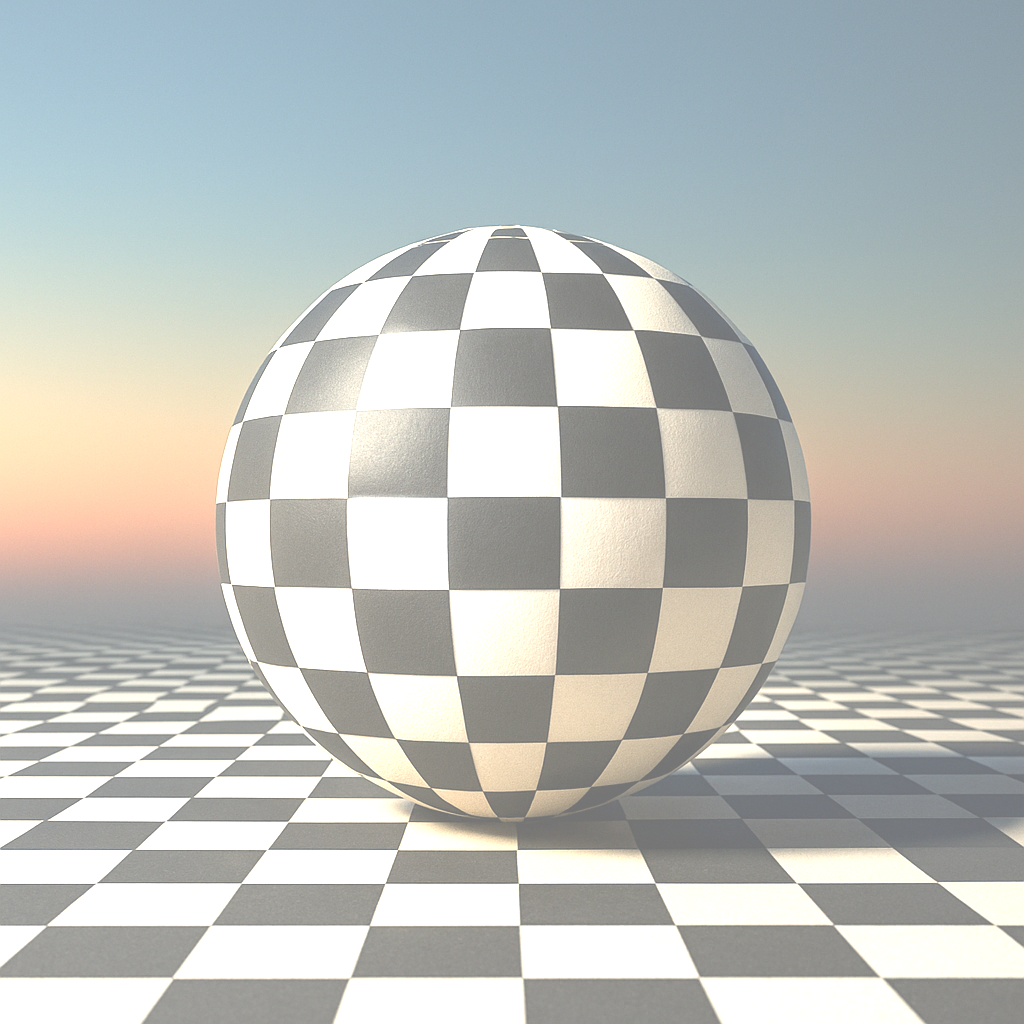

In [8]:
source_bmp : slangpy.Bitmap = slangpy.Bitmap("example.png").convert(
    pixel_format=slangpy.Bitmap.PixelFormat.rgba,
    component_type=slangpy.Bitmap.ComponentType.float32
)
source_bmp

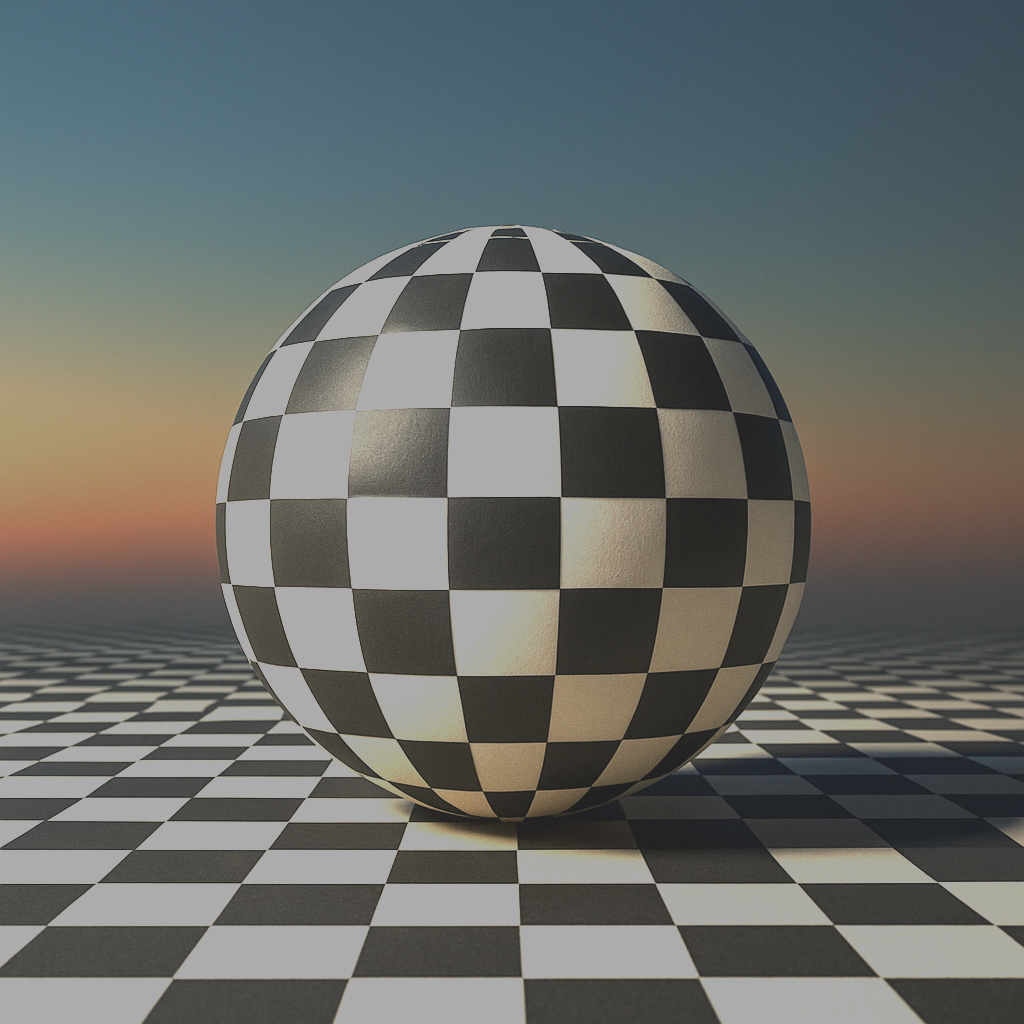

In [9]:
reference_bmp : slangpy.Bitmap = slangpy.Bitmap("example_reference.png").convert(
    pixel_format=slangpy.Bitmap.PixelFormat.rgba,
    component_type=slangpy.Bitmap.ComponentType.float32
)
reference_bmp

In [10]:
# Preparing a read–write texture: using RGBA instead of RGB for broader compatibility
source_texture : slangpy.Texture = device.create_texture(
    width=source_bmp.width,
    height=source_bmp.height,
    format=slangpy.Format.rgba32_float,
    usage=slangpy.TextureUsage.shader_resource | slangpy.TextureUsage.unordered_access,
    data=np.array(source_bmp)
)
reference_array : torch.Tensor = torch.from_numpy(np.array(reference_bmp)).to('cuda')

### Optimization Loop: Fitting the Brightness Offset

In this cell we iteratively adjust a small RGB brightness offset so that our Slang shader’s output image matches a given reference. We use:

1. An Adam optimizer to update the learnable `amount` tensor.  
2. A forward pass through the shader (`module.brightness`) to produce the brightened image.  
3. A mean absolute error (L1) loss comparing the shader output to the reference.  
4. Backpropagation (`loss.backward()`) to compute gradients w.r.t. `amount`.  
5. An optimizer step to update `amount`, and print progress every 250 iterations.

By the end, `amount` should converge to values that minimize the MAE between the two images.

In [11]:
# 1) Load the compiled Slang shader as a PyTorch‐compatible module.
#    This lets us call its entry‐points like regular PyTorch functions.
module = slangpy.TorchModule.load_from_file(device, "examples.slang")

# 2) Initialize a small 3-component brightness offset (R, G, B).
#    We’ll learn this so that brightening `source_texture` matches `reference_array`.
amount = torch.tensor([-0.1, 0.1, 0.0, 1.0],
                      dtype=torch.float32,
                      device='cuda',
                      requires_grad=True)  # enable gradient tracking

# 3) Create an optimizer wrapping our learnable parameter.
#    Adam adapts per‐parameter learning rates for more stable convergence.
opt = torch.optim.Adam([amount], lr=1e-3)

# 4) Run the optimization loop
iters = 10000
for i in range(iters):
    # a) Zero out gradients from the previous iteration
    opt.zero_grad()

    # b) Forward pass: call the Slang shader entry-point "brightness"
    #    It returns a tensor of the same shape as `source_texture`.
    result = module.brightness(amount, source_texture)

    # c) Compute the mean absolute error (L1) between the output and reference
    loss = F.l1_loss(result, reference_array)

    # d) Backward pass: populate `amount.grad` with d(loss)/d(amount)
    loss.backward()

    # e) Update `amount` using the computed gradients
    opt.step()

    # f) Every 250 iterations, print progress and current brightness values
    if (i + 1) % 250 == 0:
        current = amount.detach().cpu().numpy()
        print(f"Iter {i + 1:4d} | loss = {loss.item():.6f} | amount = {current}")

# 5) After optimization, show the final learned brightness offset
print("Final amount:", amount.detach().cpu().numpy())

Iter  250 | loss = 13.188977 | amount = [-0.10455883  0.09544118 -0.00455889  1.        ]
Iter  500 | loss = 153.081543 | amount = [-0.1087836   0.09107467 -0.008986    1.        ]
Iter  750 | loss = 292.973633 | amount = [-0.1087836   0.09107467 -0.00898601  1.        ]
Iter 1000 | loss = 432.865295 | amount = [-0.1087836   0.09107467 -0.00898601  1.        ]
Iter 1250 | loss = 26.062336 | amount = [-0.1087836   0.09107467 -0.00898601  1.        ]
Iter 1500 | loss = 165.954926 | amount = [-0.11672619  0.08179419 -0.01899525  1.        ]
Iter 1750 | loss = 305.846863 | amount = [-0.11672619  0.08179419 -0.01899525  1.        ]
Iter 2000 | loss = 445.738586 | amount = [-0.11672619  0.08179419 -0.01899525  1.        ]
Iter 2250 | loss = 38.939255 | amount = [-0.11672619  0.08179419 -0.01899525  1.        ]
Iter 2500 | loss = 178.831863 | amount = [-0.12946638  0.06733309 -0.03428708  1.        ]
Iter 2750 | loss = 318.723694 | amount = [-0.12946638  0.06733309 -0.03428708  1.        ]
It

Results:

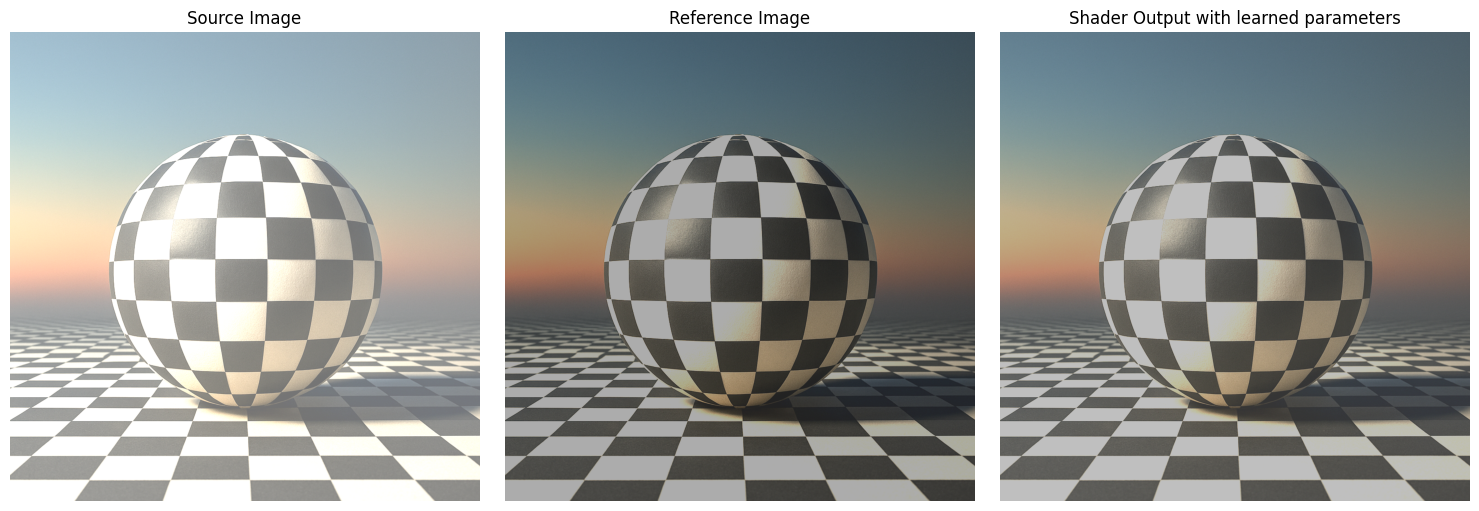

In [12]:
result = module.brightness_inplace(amount, source_texture)
result_bmp = source_texture.to_bitmap()

fig, axes = plt.subplots(1, 3, figsize=(15,5), tight_layout=True)
axes[0].imshow(source_bmp); axes[0].set_title("Source Image")
axes[1].imshow(reference_bmp); axes[1].set_title("Reference Image")
axes[2].imshow(result_bmp); axes[2].set_title("Shader Output with learned parameters")
for ax in axes:
    ax.axis("off")
plt.show()